This notebook will take DHS sites from mouse ES and label them by promoter, enhancer, CTCF, and DHS (using ChromHMM). We will then center these annotations, and finally we will calculate directionality scores based on their transcriptional activity.

In [17]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import collections
import scipy
import scipy.stats
csv.register_dialect("textdialect", delimiter='\t')
HOME = "/home/raflynn/directionality"
! mkdir interm/nb1
%matplotlib inline

mkdir: cannot create directory `interm/nb1': File exists


## ChromHMM

Get chromatin state data (mm9) from https://github.com/gireeshkbogu/chromatin_states_chromHMM_mm9

In [9]:
%%bash
cd /home/raflynn/directionality/data
curl -LOk https://github.com/gireeshkbogu/chromatin_states_chromHMM_mm9/raw/master/mESC_cStates_HMM.zip
unzip mESC_cStates_HMM.zip
mv mESC_cStates_HMM mESC_cStates_HMM.bed
rm -f mESC_cStates_HMM.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3801k  100 3801k    0     0  3238k      0  0:00:01  0:00:01 --:--:-- 3238k
Archive:  mESC_cStates_HMM.zip
  inflating: mESC_cStates_HMM        


In [10]:
%%bash

cd /home/raflynn/directionality/data
head mESC_cStates_HMM.bed

track	name='mESC'	description='mESC'	visibility=2	itemRgb="On"				
chr1	0	3037000	13_Heterochrom	0	.	0	3037000	245,245,245
chr1	10000000	10011000	14_Heterochrom	0	.	10000000	10011000	245,245,245
chr1	10011000	10013800	2_Weak_Txn	0	.	10011000	10013800	153,255,102
chr1	10013800	10015000	1_Txn_Elongation	0	.	10013800	10015000	0,176,80
chr1	10015000	10016000	2_Weak_Txn	0	.	10015000	10016000	153,255,102
chr1	10016000	10025600	1_Txn_Elongation	0	.	10016000	10025600	0,176,80
chr1	100250800	100370400	13_Heterochrom	0	.	100250800	100370400	245,245,245
chr1	10025600	10027400	2_Weak_Txn	0	.	10025600	10027400	153,255,102
chr1	10027400	10027600	5_Active_Promoter	0	.	10027400	10027600	245,0,0


## ATACseq

Get ATACseq data from Flynn 6hr and 12hr 7SK ASO controls: here we want a merged list of peaks from 6C1, 6C2, 12C1, and 12C2. How many actually overlap?

In [67]:
%%bash

# we have narrowPeak files for 4 ATACseq replicates; 
# let's keep all peaks with at least 2 replicates supporting them
cd data/atacseq
wc -l *.narrowPeak
bedtools multiinter -i 6C1_default_peaks.narrowPeak 6C2_default_peaks.narrowPeak \
12C1_default_peaks.narrowPeak 12C2_default_peaks.narrowPeak -g mm9.sizes > \
../../interm/nb1/ATAC_4reps_overlap.bed

  11654 12C1_default_peaks.narrowPeak
  20429 12C2_default_peaks.narrowPeak
  16596 6C1_default_peaks.narrowPeak
  18205 6C2_default_peaks.narrowPeak
  66884 total


In [74]:
peaks = pd.read_table("interm/nb1/ATAC_4reps_overlap.bed", header=None)
peaks.columns = ["chr", "start", "stop", "num", "which", "6C1", "6C2", "12C1", "12C2"]
print peaks.shape
peaks.head()

(105321, 9)


,chr,start,stop,num,which,6C1,6C2,12C1,12C2
0,chr1,3472904,3473138,1,2,0,1,0,0
1,chr1,3539542,3539766,1,4,0,0,0,1
2,chr1,3660735,3660959,1,1,1,0,0,0
3,chr1,3660959,3661061,2,"1,3",1,0,1,0
4,chr1,3661061,3661159,1,3,0,0,1,0


In [ ]:
peaks_two = peaks.loc[peaks["num"] > 1,:]
peaks_two.shape

In [78]:
# combine adjacent rows only if the rows have at least 2 supports

with open("interm/nb1/ATAC_4reps_overlap2.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    prev = ['initial', 0, 0, 0, 0, '+']
    ctr = 1
    for i in range(peaks.shape[0]):
        row = peaks.iloc[i]
        if row["num"] < 2: continue
        if row["chr"] == prev[0] and row["start"] == prev[2]:
            prev[2] = row["stop"]
        else:
            if prev[0] != "initial":
                prev = list(prev)
                prev.extend(["ATACpeak_{}".format(ctr), 0, '+'])
                ctr += 1
                writer.writerow(prev)
            prev = row[:3]
    prev = list(prev)
    prev.extend(["ATACpeak_{}".format(ctr), 0, '+'])
    writer.writerow(prev)  # fencepost
! wc -l interm/nb1/ATAC_4reps_overlap2.bed

18284 interm/nb1/ATAC_4reps_overlap2.bed


If we drop the 2-replicate filter, then there are 26257 ATAC-seq peaks. This might not be enough... maybe let's lower the MACS2 threshold?

## DHS data

We'll get bedgraphs for ATACseq, E14, and CJ7 and look at correlations for ATAC-seq peaks and DNase-seq peaks. The idea is that if these two non-V6.5 samples have similar DHS sites and distributions then we can use those instead of ATAC-seq which is less well sequenced. 

In [57]:
%% bash
cd data
mkdir dnase-seq; cd dnase-seq
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEscj7S129ME0SigRep1.bigWig
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEscj7S129ME0PkRep1.narrowPeak.gz
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEscj7S129ME0PkRep2.narrowPeak.gz
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEscj7S129ME0SigRep2.bigWig
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEse14129olaME0PkRep1.narrowPeak.gz
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEse14129olaME0SigRep1.bigWig
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEse14129olaME0PkRep2.narrowPeak.gz
curl -LOk http://hgdownload.cse.ucsc.edu/goldenPath/mm9/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseEse14129olaME0SigRep2.bigWig

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  188M  100  188M    0     0  30.2M      0  0:00:06  0:00:06 --:--:-- 30.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1929k  100 1929k    0     0  13.2M      0 --:--:-- --:--:-- --:--:-- 17.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1975k  100 1975k    0     0  14.6M      0 --:--:-- --:--:-- --:--:-- 18.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189M  100  189M    0     0  30.6M      0  0:00:06  0:00:06 --:--:-- 31.1M
  % Total    % Received % Xferd  Average Speed   Tim

In [62]:
%%bash
cd data/dnase-seq
gunzip *.gz
parallel bigWigToBedGraph {} {.}.bedGraph ::: *.bigWig

gunzip: *.gz: No such file or directory


In [68]:
%%bash
cd data/dnase-seq
wc -l *eak

  159331 wgEncodeUwDnaseEscj7S129ME0PkRep1.narrowPeak
  162584 wgEncodeUwDnaseEscj7S129ME0PkRep2.narrowPeak
  175237 wgEncodeUwDnaseEse14129olaME0PkRep1.narrowPeak
  155871 wgEncodeUwDnaseEse14129olaME0PkRep2.narrowPeak
  653023 total


In [72]:
%%bash
cd data/dnase-seq
bedtools multiinter -i wgEncodeUwDnaseEscj7S129ME0PkRep1.narrowPeak wgEncodeUwDnaseEscj7S129ME0PkRep2.narrowPeak \
-g ../mm9.sizes > ../../interm/nb1/DNase_CJ7_overlap.bed
bedtools multiinter -i wgEncodeUwDnaseEse14129olaME0PkRep1.narrowPeak wgEncodeUwDnaseEse14129olaME0PkRep2.narrowPeak \
-g ../mm9.sizes > ../../interm/nb1/DNase_E14_overlap.bed
wc -l ../../interm/nb1/DNase_CJ7_overlap.bed
wc -l ../../interm/nb1/DNase_E14_overlap.bed

366229 ../../interm/nb1/DNase_CJ7_overlap.bed
378808 ../../interm/nb1/DNase_E14_overlap.bed


Get overlapping peaks

In [150]:
peaks = pd.read_table("interm/nb1/DNase_CJ7_overlap.bed", header=None)
peaks.columns = ["chr", "start", "stop", "num", "which", "Rep1", "Rep2"]
with open("interm/nb1/DNase_CJ7_overlap2.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    prev = ['initial', 0, 0]
    ctr = 1
    for i in range(peaks.shape[0]):
        row = peaks.iloc[i]
        if row["num"] != 2: continue
        if row["chr"] == prev[0] and row["start"] == prev[2]:
            prev[2] = row["stop"]
        else:
            if prev[0] != "initial":
                prev = list(prev)
                prev.extend(["DHSpeak_{}".format(ctr), 0, '+'])
                ctr += 1
                writer.writerow(prev)
            prev = row[:3]
    prev = list(prev)
    prev.extend(["DHSpeak_{}".format(ctr), 0, '+'])
    writer.writerow(prev)  # fencepost
! wc -l interm/nb1/DNase_CJ7_overlap2.bed

peaks = pd.read_table("interm/nb1/DNase_E14_overlap.bed", header=None)
peaks.columns = ["chr", "start", "stop", "num", "which", "Rep1", "Rep2"]
with open("interm/nb1/DNase_E14_overlap2.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    prev = ['initial', 0, 0]
    ctr = 1
    for i in range(peaks.shape[0]):
        row = peaks.iloc[i]
        if row["num"] != 2: continue
        if row["chr"] == prev[0] and row["start"] == prev[2]:
            prev[2] = row["stop"]
        else:
            if prev[0] != "initial":
                prev = list(prev)
                prev.extend(["DHSpeak_{}".format(ctr), 0, '+'])
                ctr += 1
                writer.writerow(prev)
            prev = row[:3]
    prev = list(prev)
    prev.extend(["DHSpeak_{}".format(ctr), 0, '+'])
    writer.writerow(prev)  # fencepost
! wc -l interm/nb1/DNase_E14_overlap2.bed

123330 interm/nb1/DNase_CJ7_overlap2.bed
97855 interm/nb1/DNase_E14_overlap2.bed


Run metagene maker on all DHS and ATAC-seq bedgraphs and DHS and ATAC-seq peaks, then compareDifferentRegions

In [ ]:
%%bash
cd interm
mkdir metagenes
metagene_maker -p 12 nb1/160424_mES_ATACseq_DNase.txt DHS metagenes &
cd metagenes
compareDifferentRegions ../nb1/160424_mES_ATACseq_DNase_regionList.txt DHS

Do correlation analysis

In [86]:
atac_peaks = pd.read_table("interm/metagenes/regionLists/ATAC_v65_merged_peaks_list_DHS.txt")
atac_peaks.head()

,regionName,ATACseq_v65_12C,ATACseq_v65_6C,Dnase_CJ7_rep1,Dnase_CJ7_rep2,Dnase_E14_rep1,Dnase_E14_rep2
0,chr10__100051769__100051953__ATACpeak_1851__0__+,1.527939,1.434951,80.940217,98.489130,57.385870,18.467391
1,chr10__102131198__102131421__ATACpeak_1852__0__+,1.601363,1.284468,1.923767,1.206278,0.000000,0.690583
2,chr10__102676505__102676705__ATACpeak_1853__0__+,1.282458,1.627678,0.315000,0.000000,0.105000,0.005000
3,chr10__102809533__102809767__ATACpeak_1854__0__+,1.302820,1.047232,40.747863,40.230769,52.589744,41.269231
4,chr10__102831707__102832062__ATACpeak_1855__0__+,1.933466,1.662484,167.957746,142.307042,99.400000,70.729577


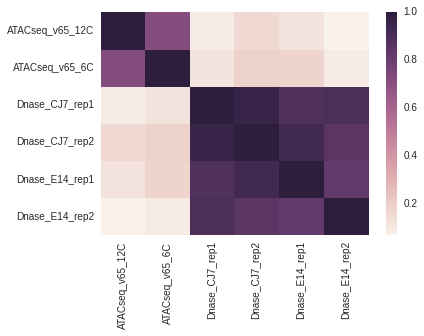

In [104]:
sns.heatmap(atac_peaks.corr(method="spearman"))

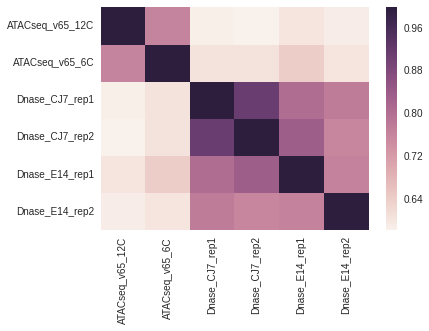

In [105]:
cj7_peaks = pd.read_table("interm/metagenes/regionLists/Dnase_CJ7_merged_peaks_list_DHS.txt")
sns.heatmap(cj7_peaks.corr(method="spearman"))

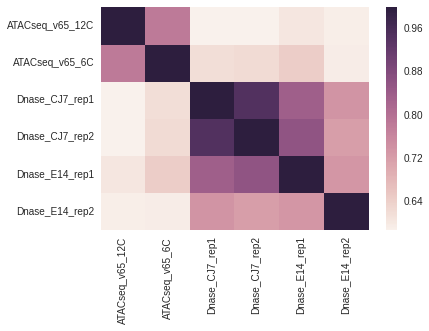

In [57]:
e14_peaks = pd.read_table("interm/metagenes/regionLists/Dnase_E14_merged_peaks_list_DHS.txt")
sns.heatmap(e14_peaks.corr(method="spearman"))

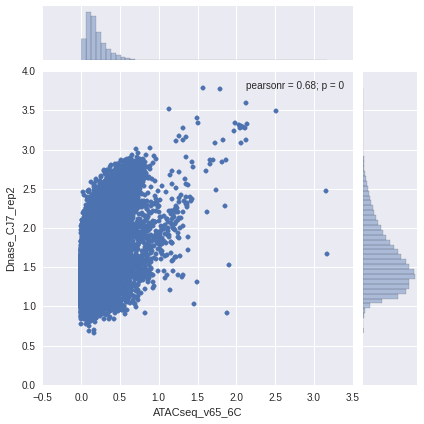

In [129]:
sns.jointplot(x="ATACseq_v65_6C", y="Dnase_CJ7_rep2", data=np.log10(cj7_peaks.ix[:,1:]+1))

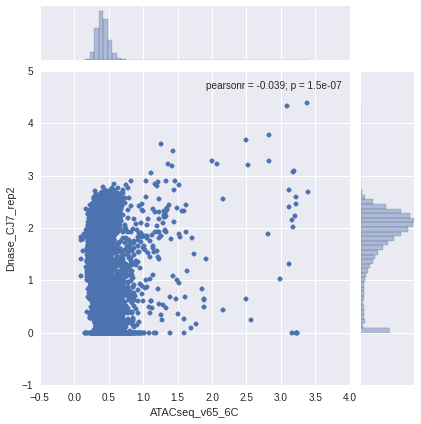

In [128]:
sns.jointplot(x="ATACseq_v65_6C", y="Dnase_CJ7_rep2", data=np.log10(atac_peaks.ix[:,1:]+1))

In [130]:
! bedtools intersect -a interm/nb1/ATAC_4reps_overlap2.bed -b interm/nb1/DNase_CJ7_overlap2.bed -wa -u | wc -l

15192


In [131]:
! bedtools intersect -a interm/nb1/ATAC_4reps_overlap2.bed -b interm/nb1/DNase_E14_overlap2.bed -wa -u | wc -l

14162


In [134]:
! bedtools intersect -a interm/nb1/DNase_E14_overlap2.bed -b interm/nb1/DNase_CJ7_overlap2.bed -wa -u | wc -l

73346


## Label DHS sites by type, and do some simple stats

Arbitrarily, we are using E14 peaks

In [18]:
! bedtools intersect -a interm/nb1/DNase_E14_overlap2.bed -b interm/nb1/DNase_CJ7_overlap2.bed -wa -u \
> interm/nb1/160427_dhs_list.bed
! head interm/nb1/160427_dhs_list.bed

chr1	3052980	3053130	DHSpeak_1	0	+
chr1	3333680	3333810	DHSpeak_2	0	+
chr1	3435860	3435930	DHSpeak_3	0	+
chr1	3473020	3473170	DHSpeak_4	0	+
chr1	3660860	3660990	DHSpeak_7	0	+
chr1	3661820	3661910	DHSpeak_8	0	+
chr1	3671680	3671810	DHSpeak_9	0	+
chr1	3943820	3943930	DHSpeak_11	0	+
chr1	4132680	4132830	DHSpeak_13	0	+
chr1	4322680	4322750	DHSpeak_14	0	+


Get centers of every DHS site, and intersect with ChromHMM

In [16]:
! awk -F "\t" "BEGIN {OFS=\"\t\"} {print \$1, (\$2+\$3)/2, (\$2+\$3)/2 + 1, \$4, \$5, \$6}" \
interm/nb1/160427_dhs_list.bed > interm/nb1/160427_dhs_list_centers.bed
! bedtools intersect -a interm/nb1/160427_dhs_list_centers.bed -b data/mESC_cStates_HMM.bed -wa -wb \
> interm/nb1/160427_dhs_list_centers_labeled_temp.bed
! wc -l interm/nb1/160427_dhs_list_centers_labeled_temp.bed
! head interm/nb1/160427_dhs_list_centers_labeled_temp.bed

73345 interm/nb1/160427_dhs_list_centers_labeled_temp.bed
chr1	3053055	3053056	DHSpeak_1	0	+	chr1	3040600	3105000	13_Heterochrom	0	.	3040600	3105000	245,245,245
chr1	3333745	3333746	DHSpeak_2	0	+	chr1	3313000	3387600	12_Heterochrom	0	.	3313000	3387600	245,245,245
chr1	3435895	3435896	DHSpeak_3	0	+	chr1	3388400	3471000	12_Heterochrom	0	.	3388400	3471000	245,245,245
chr1	3473095	3473096	DHSpeak_4	0	+	chr1	3471000	3475200	11_Repressed	0	.	3471000	3475200	127,127,127
chr1	3660925	3660926	DHSpeak_7	0	+	chr1	3660600	3662800	10_Poised_Promoter	0	.	3660600	3662800	207,11,198
chr1	3661865	3661866	DHSpeak_8	0	+	chr1	3660600	3662800	10_Poised_Promoter	0	.	3660600	3662800	207,11,198
chr1	3671745	3671746	DHSpeak_9	0	+	chr1	3664800	3786400	12_Heterochrom	0	.	3664800	3786400	245,245,245
chr1	3943875	3943876	DHSpeak_11	0	+	chr1	3934400	3966800	12_Heterochrom	0	.	3934400	3966800	245,245,245
chr1	4132755	4132756	DHSpeak_13	0	+	chr1	4132600	4133000	15_Insulator	0	.	4132600	4133000	10,190,254
chr1	4322715

In [22]:
! awk -F "\t" "BEGIN {OFS=\"\t\"} {print \$1, \$2, \$3, \$4 \"__\" \$10, \$5, \$6}" \
interm/nb1/160427_dhs_list_centers_labeled_temp.bed > interm/nb1/160427_dhs_list_centers_labeled.bed

In [18]:
dhs_labeled = pd.read_table("interm/nb1/160605_dhs_grodirec_sorted.bed", header=None)
dhs_labeled.head()

,0,1,2,3,4,5
0,chr1,3051710,3053710,chr1__3051710__3053710__3053055__DHSpeak_1__13...,2.711702,+
1,chr1,3332745,3334745,chr1__3332745__3334745__3333745__DHSpeak_2__12...,0.475715,-
2,chr1,3434895,3436895,chr1__3434895__3436895__3435895__DHSpeak_3__12...,0.000000,+
3,chr1,3472095,3474095,chr1__3472095__3474095__3473095__DHSpeak_4__11...,3.256955,-
4,chr1,3659925,3661925,chr1__3659925__3661925__3660925__DHSpeak_7__10...,inf,-


{'Active_Promoter': 16506, 'Txn_Transition': 1512, 'Poised_Promoter': 3228, 'Strong_Enhancer': 13667, 'Poised_Enhancer': 673, 'Txn_Elongation': 2318, 'Insulator': 7966, 'Weak_Txn': 3453, 'Heterochrom': 18169, 'Repressed': 3083}


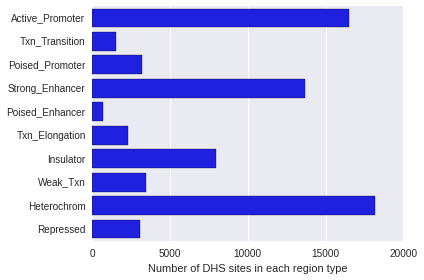

In [26]:
from collections import Counter
def process_name(x):
    x = x.split('__')[5]
    return '_'.join(x.split('_')[1:])

cts = dict(Counter(list(dhs_labeled[3].apply(process_name))))
print cts
sns.barplot(cts.values(), cts.keys(), color="blue")
sns.plt.xlabel("Number of DHS sites in each region type")
sns.plt.tight_layout()
sns.plt.savefig("figures/num_dhssites_perregion.pdf")

Observed vs expected??

In [21]:
regiontype_to_ct = collections.defaultdict(lambda: 0)
with open("data/mESC_cStates_HMM.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    reader.next()
    for row in reader:
        ct = int(row[2]) - int(row[1])
        name = '_'.join(row[3].split('_')[1:])
        regiontype_to_ct[name] += ct
regiontype_to_ct

defaultdict(<function __main__.<lambda>>,
            {'Active_Promoter': 26705200,
             'Heterochrom': 2150468600,
             'Insulator': 6055000,
             'Poised_Enhancer': 2694200,
             'Poised_Promoter': 9822000,
             'Repressed': 85307800,
             'Strong_Enhancer': 64835000,
             'Txn_Elongation': 109928000,
             'Txn_Transition': 11679600,
             'Weak_Txn': 187397800})

{'Active_Promoter': 23.251028809173082, 'Txn_Transition': 4.869899402243952, 'Poised_Promoter': 12.363167822738907, 'Strong_Enhancer': 7.929756426445714, 'Poised_Enhancer': 9.396830664936076, 'Txn_Elongation': 0.7932339131686311, 'Insulator': 49.490554861695536, 'Weak_Txn': 0.6931516455423713, 'Heterochrom': 0.3178294143476198, 'Repressed': 1.3595054438101632}


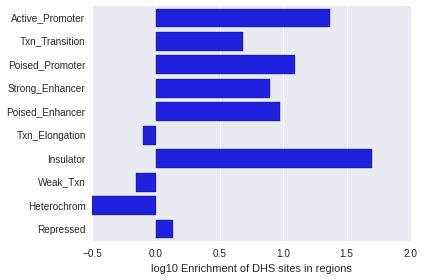

In [25]:
total_genome = np.sum(regiontype_to_ct.values())
exp_ratio = {}
for region in regiontype_to_ct:
    exp_ratio[region] = float(regiontype_to_ct[region])/total_genome
total_regions = np.sum(cts.values())
obs_over_exp = {}
for region in cts:
    obs_over_exp[region] = cts[region]/float(total_regions) / exp_ratio[region]
print obs_over_exp
sns.barplot(np.log10(obs_over_exp.values()), obs_over_exp.keys(), color="blue")
sns.plt.xlabel("log10 Enrichment of DHS sites in regions")
sns.plt.tight_layout()
sns.plt.savefig("figures/enrichment_dhssites_byregion.pdf")

Height of DHS peaks at each of these regions

In [104]:
e14_peaks = pd.read_table("interm/metagenes/regionLists/Dnase_E14_merged_peaks_list_DHS.txt")
e14_peaks["regionName"] = e14_peaks["regionName"].apply(lambda x: x.split('__')[3])

In [105]:
dhs_to_region = pd.DataFrame.from_dict(dict(dhs_labeled[3].apply(lambda x: x.split('__')))).transpose()
dhs_to_region.columns = ["regionName", "regionType"]
dhs_to_region["regionType"] = dhs_to_region["regionType"].apply(lambda x: '_'.join(x.split('_')[1:]))
dhs_to_region.head()

,regionName,regionType
0,DHSpeak_1,Heterochrom
1,DHSpeak_2,Heterochrom
2,DHSpeak_3,Heterochrom
3,DHSpeak_4,Repressed
4,DHSpeak_7,Poised_Promoter


In [106]:
e14_peaks = e14_peaks.merge(dhs_to_region, on="regionName")
e14_peaks.head()

,regionName,ATACseq_v65_12C,ATACseq_v65_6C,Dnase_CJ7_rep1,Dnase_CJ7_rep2,Dnase_E14_rep1,Dnase_E14_rep2,regionType
0,DHSpeak_10229,1.277778,1.448402,105.692308,123.876923,73.138462,20.184615,Active_Promoter
1,DHSpeak_10230,0.323767,0.358890,22.584615,26.984615,30.676923,9.353846,Heterochrom
2,DHSpeak_6386,0.790636,0.801958,33.618182,63.945455,56.272727,17.163636,Heterochrom
3,DHSpeak_6387,0.412609,0.520425,39.753846,35.692308,27.476923,14.015385,Heterochrom
4,DHSpeak_10232,0.906906,0.769437,16.428571,19.400000,7.342857,8.028571,Heterochrom


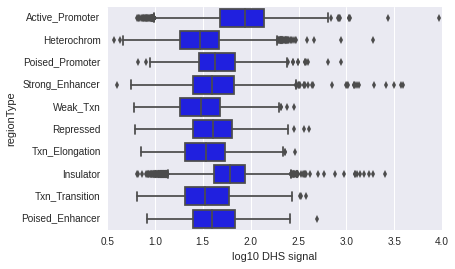

In [108]:
sns.boxplot(x=np.log10(e14_peaks["Dnase_E14_rep1"]), y=e14_peaks["regionType"], color="blue")
sns.plt.xlabel("log10 DHS signal")

## Centering DHS's by Start-seq signal

Most of this code is taken from work done in April 2015 to use Start-seq signal to center enhancers and TSS; see https://github.com/bdo311/7sk-analysis/tree/626ef5bdc3122ba73f056864d6dca3c5a44778d9/Start-RNAseq. 

Get bedgraphs from GSE43390 (Adelman lab Start-seq data): http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE43390

In [125]:
! cd data; mkdir start-seq
! cd data/start-seq && wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE43nnn/GSE43390/suppl/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph.gz
! cd data/start-seq && wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE43nnn/GSE43390/suppl/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_reverse.bedgraph.gz

mkdir: cannot create directory `start-seq': File exists
--2016-04-28 15:12:06--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE43nnn/GSE43390/suppl/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph.gz
           => `GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph.gz'
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.7, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD /geo/series/GSE43nnn/GSE43390/suppl ... done.
==> SIZE GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph.gz ... 10898256
==> PASV ... done.    ==> RETR GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph.gz ... done.
Length: 10898256 (10M)

100%[======================================>] 10,898,256  6.62M/s   in 1.6s    

2016-04-28 15:

In [126]:
! parallel gunzip {} ::: data/start-seq/*.gz 
! ls -l data/start-seq

total 112108
-rw-rw-r--. 1 raflynn raflynn 57656971 2016-04-28 15:12 GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph
-rw-rw-r--. 1 raflynn raflynn 56998823 2016-04-28 15:12 GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_reverse.bedgraph
-rw-rw-r--. 1 raflynn raflynn        0 2016-04-28 15:11 GSE43390_mESC_startRNA-seq_forward.bedgraph
-rw-rw-r--. 1 raflynn raflynn        0 2016-04-28 15:11 GSE43390_mESC_startRNA-seq_reverse.bedgraph


In [127]:
! sed -i -e "1,2d" data/start-seq/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph
! sed -i -e "1,2d" data/start-seq/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_reverse.bedgraph
! mv data/start-seq/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_forward.bedgraph data/start-seq/GSE43390_mESC_startRNA-seq_forward.bedgraph
! mv data/start-seq/GSE43390_Adelman_Bl6_mESC_C2cells_2i_Ctrl_startRNA-seq_5pr_allReps_norm_reverse.bedgraph data/start-seq/GSE43390_mESC_startRNA-seq_reverse.bedgraph

Get lines from the Start-seq bedgraph that are within 500bp of a DHS center.

In [133]:
! awk -F "\t" "BEGIN {OFS=\"\t\"} {print \$1, \$2 - 500, \$3 + 499, \$4, \$5, \$6}" \
interm/nb1/160427_dhs_list_centers_labeled.bed > interm/nb1/160427_dhs_list_pm500_labeled.bed
! bedtools intersect -a data/start-seq/GSE43390_mESC_startRNA-seq_forward.bedgraph \
-b interm/nb1/160427_dhs_list_pm500_labeled.bed -wa -wb > interm/nb1/GSE43390_mESC_startRNA-seq_forward_dhsoverlap.bedgraph
! bedtools intersect -a data/start-seq/GSE43390_mESC_startRNA-seq_reverse.bedgraph \
-b interm/nb1/160427_dhs_list_pm500_labeled.bed -wa -wb > interm/nb1/GSE43390_mESC_startRNA-seq_reverse_dhsoverlap.bedgraph

In [135]:
! head interm/nb1/GSE43390_mESC_startRNA-seq_forward_dhsoverlap.bedgraph

chr1	3052739	3052739	5.383161896	chr1	3052555	3053555	DHSpeak_1__13_Heterochrom	0	+
chr1	3660940	3660940	4	chr1	3660425	3661425	DHSpeak_7__10_Poised_Promoter	0	+
chr1	3943915	3943915	1.821498736	chr1	3943375	3944375	DHSpeak_11__12_Heterochrom	0	+
chr1	3943916	3943916	2.732248104	chr1	3943375	3944375	DHSpeak_11__12_Heterochrom	0	+
chr1	3943917	3943917	6	chr1	3943375	3944375	DHSpeak_11__12_Heterochrom	0	+
chr1	3943920	3943920	1.821498736	chr1	3943375	3944375	DHSpeak_11__12_Heterochrom	0	+
chr1	3943922	3943922	3.642997472	chr1	3943375	3944375	DHSpeak_11__12_Heterochrom	0	+
chr1	4481763	4481763	5	chr1	4481275	4482275	DHSpeak_19__10_Poised_Promoter	0	+
chr1	4481766	4481766	0.580054808	chr1	4481275	4482275	DHSpeak_19__10_Poised_Promoter	0	+
chr1	4481818	4481818	0.580054808	chr1	4481275	4482275	DHSpeak_19__10_Poised_Promoter	0	+


Make dictionaries of DHS to all positions with signal.

In [136]:
def getPos(fn):
    ifile = open(fn,'r')
    reader = csv.reader(ifile, 'textdialect')
    enh = collections.defaultdict(lambda: [])
    for row in reader:
        enhName = '__'.join(row[4:])
        row[1:4] = [int(row[1]),int(row[2]),float(row[3])]
        enh[enhName].append(row[:4])
    ifile.close()
    return enh
    
# hash tables of enhancer to all positions with signal
fdhs = getPos("interm/nb1/GSE43390_mESC_startRNA-seq_forward_dhsoverlap.bedgraph")
rdhs = getPos("interm/nb1/GSE43390_mESC_startRNA-seq_reverse_dhsoverlap.bedgraph")

Get forward and reverse "peaks" for each DHS
- we are assuming the reverse peak must be upstream of the forward peak
- we are assuming that the forward and reverse peaks are within 500bp of the DHS center
    - this makes sense because the peaks were originally 150bp in size 
- we want to maximize the sum of reverse and forward signal given the prior constraint
- if there is no signal on one or both strands, we report the one strand where there is signal, or we report no signal

In [151]:
# optimal enhancer reverse and forward starts
ofile = open("interm/nb1/160427_dhs_fwd_rev.txt",'w')
writer = csv.writer(ofile, 'textdialect')

# bidirectional
bidir_dhs = set()
for dhs in fdhs:
    if dhs not in rdhs: continue
    bestR = []
    bestF = []
    maxSum = 0
    
    for rSignal in rdhs[dhs]:
        for fSignal in fdhs[dhs]:           
            if rSignal[1] >= fSignal[1]: continue # r must be < f
            sigSum = rSignal[3] + fSignal[3]
            if sigSum > maxSum:
                maxSum = sigSum
                bestR = rSignal
                bestF = fSignal
                
    if maxSum == 0: continue #no reverse signal before forward signal
    bidir_dhs.add(dhs)
    r = dhs.split('__')
    outputRow = [r[0], r[1], r[2], r[3] + '__' + r[4], r[5], r[6]]
    outputRow.extend(bestR)
    outputRow.extend(bestF)
    outputRow.append(bestF[1]-bestR[1])  # distance between peaks
    writer.writerow(outputRow)
    
# unidirectional; get forward only then backward
unidir_dhs = set()
for dhs in fdhs:
    if dhs in bidir_dhs: continue
    bestF = []
    maxSum = 0
    for fSignal in fdhs[dhs]:
        if fSignal[3] > maxSum:
            bestF = fSignal
            maxSum = fSignal[3]
            
    unidir_dhs.add(dhs)
    r = dhs.split('__')
    outputRow = [r[0], r[1], r[2], r[3] + '__' + r[4], r[5], r[6]]
    outputRow.extend(["none", 0, 0, 0])
    outputRow.extend(bestF)
    outputRow.append(0)  # distance between peaks
    writer.writerow(outputRow)
    
for dhs in rdhs:
    if dhs in bidir_dhs or dhs in unidir_dhs: continue
    bestR = []
    maxSum = 0
    for rSignal in rdhs[dhs]:
        if rSignal[3] > maxSum:
            bestR = rSignal
            maxSum = rSignal[3]
            
    unidir_dhs.add(dhs)
    r = dhs.split('__')
    outputRow = [r[0], r[1], r[2], r[3] + '__' + r[4], r[5], r[6]]
    outputRow.extend(bestR)
    outputRow.extend(["none", 0, 0, 0])
    outputRow.append(0)  # distance between peaks
    writer.writerow(outputRow)
    
# no signal
nosignal_dhs = set()
with open("interm/nb1/160427_dhs_list_pm500_labeled.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dhs = '__'.join(row)
        if dhs in bidir_dhs or dhs in unidir_dhs: continue
        nosignal_dhs.add(dhs)
        outputRow = row
        outputRow.extend(["none", 0, 0, 0])
        outputRow.extend(["none", 0, 0, 0])
        outputRow.append(0)  # distance between peaks
        writer.writerow(outputRow)        

ofile.close()
print "Number of bidirectional: {}".format(len(bidir_dhs))
print "Number of unidirectional: {}".format(len(unidir_dhs))
print "Number with no signal: {}".format(len(nosignal_dhs))

Number of bidirectional: 43179
Number of unidirectional: 17728
Number with no signal: 12438


In [153]:
! sort -k1,1 -k2,2n interm/nb1/160427_dhs_fwd_rev.txt > interm/nb1/160427_dhs_fwd_rev_sorted.txt
! rm -f interm/nb1/160427_dhs_fwd_rev.txt
! head interm/nb1/160427_dhs_fwd_rev_sorted.txt

Where are the centers relative to the DHS site?

In [176]:
# bidirectional classifications
gapsize = []
around_dist = []
side_dist = []

# unidirectional classifications
uni_dist = []

with open("interm/nb1/160427_dhs_fwd_rev_sorted.txt", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        orig_ctr = int(row[1]) + 500
        if row[6] != "none" and row[10] != "none":  # bidirectional
            gapsize.append(int(row[-1])) 
            new_ctr = (int(row[11]) + int(row[7]))/2
            if int(row[7]) < orig_ctr and int(row[11]) > orig_ctr:  # around
                around_dist.append(np.abs(new_ctr - orig_ctr))
            else:  # side
                side_dist.append(np.abs(new_ctr - orig_ctr))
        else:  # unidirectional
            if row[6] != "none":  # txn on the left
                uni_dist.append(orig_ctr - int(row[7]))
            elif row[10] != "none":  # txn on the right
                uni_dist.append(int(row[11]) - orig_ctr)  

In [177]:
print "Start-seq based classifications -- not formal"
print "Number of bidirectional DHS's with txn on both sides of DHS center: {}".format(len(around_dist))
print "Number of bidirectional DHS's with txn on one side of DHS center: {}".format(len(side_dist))
print "Number of unidirectional DHS's: {}".format(len(uni_dist))

Start-seq based classifications -- not formal
Number of bidirectional DHS's with txn on both sides of DHS center: 30414
Number of bidirectional DHS's with txn on one side of DHS center: 12765
Number of unidirectional DHS's: 17728


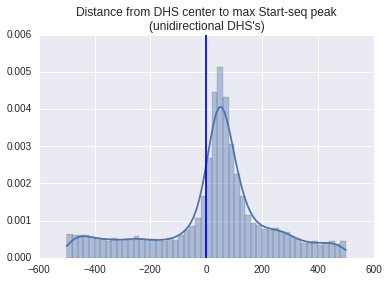

In [178]:
sns.distplot(uni_dist)
sns.plt.title("Distance from DHS center to max Start-seq peak\n(unidirectional DHS's)")
sns.plt.axvline(0)

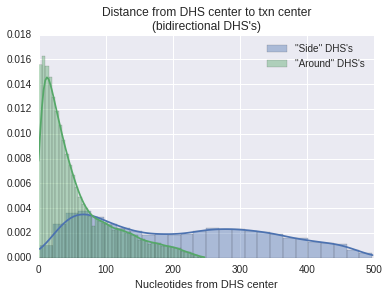

In [184]:
sns.distplot(side_dist, label="\"Side\" DHS's")
sns.distplot(around_dist, label="\"Around\" DHS's")
sns.plt.xlim([0,500])
sns.plt.legend()
sns.plt.title("Distance from DHS center to txn center\n(bidirectional DHS's)")
sns.plt.xlabel("Nucleotides from DHS center")

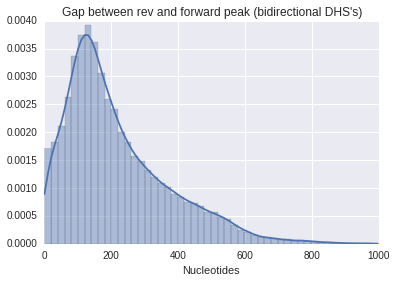

In [186]:
sns.distplot(gapsize)
sns.plt.title("Gap between rev and forward peak (bidirectional DHS's)")
sns.plt.xlabel("Nucleotides")

Get a final list of centered DHS sites. For this list, we are only considering DHS sites that have bidirectional transcription activity.

Column 1: \[chr\] 

Column 2: \[start\] 

Column 3: \[end\] 

Column 4: \[old_center\]\__\[DHSpeak_num\]\__\[ChromHMM_annot\] 

Column 5: \[dist between + and - peaks\] 

Column 6: \[strand\]

In [190]:
with open("interm/nb1/160427_dhs_fwd_rev_sorted.txt", 'r') as ifile, \
open("interm/nb1/160427_dhs_startseq_ctr_pm1kb.bed", 'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    for row in reader:
        if row[6] == "none" or row[10] == "none":  # not bidirectional
            ctr = int(row[1]) + 500
            if row[6] == "none" and row[10] == "none": direc = "nostartseqsig"
            else: direc = "uni"
        else: 
            ctr = (int(row[7]) + int(row[11]))/2
            direc = "bidir"
        outputRow = [row[0], ctr - 1000, ctr + 1000, "name", row[-1], row[5]]
        outputRow[3] = '__'.join([str(int(row[1]) + 500), direc, row[3]])
        writer.writerow(outputRow)
! head interm/nb1/160427_dhs_startseq_ctr_pm1kb.bed

## Directionality scores using GROseq and Start-seq

We have 43,179 DHS sites with some bidirectional transcription and can now quantify directional transcription using both GROseq and Start-seq. 

Can we also use the uni and no-txn sites? We can use the DHS center. we know that at least for the unidirectionals, the DHS center is just upstream of the txn center.

Steps
1. We'll run metagene maker on both Start-seq and GROseq data at all these sites, and then calculate directionality
2. Compare directionality scores calculated by different replicates of Start-seq and GROseq
3. See if directionality at promoter-overlapping DHS's matches RefSeq annotations

In [193]:
%%bash
# make bedgraph lines <chrN> <x> <x+1> <ct> instead of <chrN> <x> <x> <ct> which mgm doesn't like

cd data/start-seq
awk -F "\t" "BEGIN {OFS=\"\t\"} {print \$1, \$2, \$3 + 1, \$4}" \
GSE43390_mESC_startRNA-seq_forward.bedgraph > GSE43390_mESC_startRNA-seq_forward_1bp.bedgraph
awk -F "\t" "BEGIN {OFS=\"\t\"} {print \$1, \$2, \$3 + 1, \$4}" \
GSE43390_mESC_startRNA-seq_reverse.bedgraph > GSE43390_mESC_startRNA-seq_reverse_1bp.bedgraph

In [ ]:
%%bash
cd interm
metagene_maker -p 12 nb1/160429_mES_DHScentered_grostart.txt DHScentered metagenes

In [ ]:
%%bash
cd interm/metagenes
compareDifferentRegions ../nb1/160430_mES_DHScentered_grostart_sense_regionList.txt downstream_sense
compareDifferentRegions ../nb1/160430_mES_DHScentered_grostart_antisense_regionList.txt upstream_antisense

In [452]:
sense = pd.read_table("interm/metagenes/regionLists/DHS_Startseq_centered_list_downstream_sense.txt")
antisense = pd.read_table("interm/metagenes/regionLists/DHS_Startseq_centered_list_upstream_antisense.txt")
sense.columns = ["regionName", "GRO1", "GRO2", "GRO3", "GRO4", "GROcomb", "Startseq"]
antisense.columns = ["regionName", "GRO1", "GRO2", "GRO3", "GRO4", "GROcomb", "Startseq"]

In [230]:
sense.head()

,regionName,GRO1,GRO2,GRO3,GRO4,GROcomb,Startseq
0,chr10__100050901__100052901__100051905__bidir_...,0,0.203794,1.964309,2.110425,1.069632,0.094920
1,chr10__100203865__100205865__100204865__nostar...,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,chr10__10040115__10042115__10041115__uni__DHSp...,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,chr10__10074565__10076565__10075565__nostartse...,0,0.000000,0.000000,0.000000,0.000000,0.000000
4,chr10__101044763__101046763__101045955__bidir_...,0,0.000000,0.211578,0.000000,0.052895,0.075508


In [231]:
antisense.head()

,regionName,GRO1,GRO2,GRO3,GRO4,GROcomb,Startseq
0,chr10__100050901__100052901__100051905__bidir_...,8.544688,2.575605,5.257350,4.916481,5.323531,3.984401
1,chr10__100203865__100205865__100204865__nostar...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,chr10__10040115__10042115__10041115__uni__DHSp...,0.000000,0.000000,0.363874,0.000000,0.090968,0.208800
3,chr10__10074565__10076565__10075565__nostartse...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,chr10__101044763__101046763__101045955__bidir_...,0.000000,0.238867,0.218324,0.416811,0.218501,0.002275


In [453]:
log_direc = np.log2(sense.ix[:,1:]/antisense.ix[:,1:])
log_direc.index = sense["regionName"]
log_direc.head(10)

,GRO1,GRO2,GRO3,GRO4,GROcomb,Startseq
regionName,,,,,,
chr10__100050901__100052901__100051905__bidir__DHSpeak_10229__7_Active_Promoter__64__+,-inf,-3.659725,-1.420314,-1.220092,-2.315269,-5.391503
chr10__100203865__100205865__100204865__nostartseqsig__DHSpeak_10230__12_Heterochrom__0__+,NaN,NaN,NaN,NaN,NaN,NaN
chr10__10040115__10042115__10041115__uni__DHSpeak_6386__12_Heterochrom__0__+,NaN,NaN,-inf,NaN,-inf,-inf
chr10__10074565__10076565__10075565__nostartseqsig__DHSpeak_6387__12_Heterochrom__0__+,NaN,NaN,NaN,NaN,NaN,NaN
chr10__101044763__101046763__101045955__bidir__DHSpeak_10232__12_Heterochrom__476__+,NaN,-inf,-0.045283,-inf,-2.046448,5.052868
chr10__101479116__101481116__101480055__bidir__DHSpeak_10233__12_Heterochrom__236__+,inf,NaN,0.096926,0.148447,1.974238,-1.715917
chr10__101832355__101834355__101833355__uni__DHSpeak_10234__12_Heterochrom__0__+,NaN,-0.431583,-1.344943,-inf,-1.520350,-inf
chr10__10191225__10193225__10192225__uni__DHSpeak_6388__5_Active_Promoter__0__+,NaN,NaN,-inf,NaN,-inf,-inf
chr10__101913595__101915595__101914595__uni__DHSpeak_10235__12_Heterochrom__0__+,NaN,NaN,NaN,NaN,NaN,NaN


In [454]:
log_total = np.log2(sense.ix[:,1:] + antisense.ix[:,1:])
log_total.index = sense["regionName"]
log_total.head(10)

,GRO1,GRO2,GRO3,GRO4,GROcomb,Startseq
regionName,,,,,,
chr10__100050901__100052901__100051905__bidir__DHSpeak_10229__7_Active_Promoter__64__+,3.095028,1.474773,2.852330,2.812890,2.676530,2.028329
chr10__100203865__100205865__100204865__nostartseqsig__DHSpeak_10230__12_Heterochrom__0__+,-inf,-inf,-inf,-inf,-inf,-inf
chr10__10040115__10042115__10041115__uni__DHSpeak_6386__12_Heterochrom__0__+,-inf,-inf,-1.458490,-inf,-3.458490,-2.259805
chr10__10074565__10076565__10075565__nostartseqsig__DHSpeak_6387__12_Heterochrom__0__+,-inf,-inf,-inf,-inf,-inf,-inf
chr10__101044763__101046763__101045955__bidir__DHSpeak_10232__12_Heterochrom__476__+,-inf,-2.065723,-1.217919,-1.262533,-1.881533,-3.684404
chr10__101479116__101481116__101480055__bidir__DHSpeak_10233__12_Heterochrom__236__+,1.069660,-inf,-2.162857,0.420256,-0.127992,-5.680779
chr10__101832355__101834355__101833355__uni__DHSpeak_10234__12_Heterochrom__0__+,-inf,0.734564,0.498701,0.272389,0.099174,-6.452963
chr10__10191225__10193225__10192225__uni__DHSpeak_6388__5_Active_Promoter__0__+,-inf,-inf,-4.638399,-inf,-6.638399,-5.972737
chr10__101913595__101915595__101914595__uni__DHSpeak_10235__12_Heterochrom__0__+,-inf,-inf,-inf,-inf,-inf,-inf


Plotting correlation matrices for non-NaN elements. inf and -inf count as NaN.

log_direc: 11746 non-NaN

log_total: 29540 non-NaN

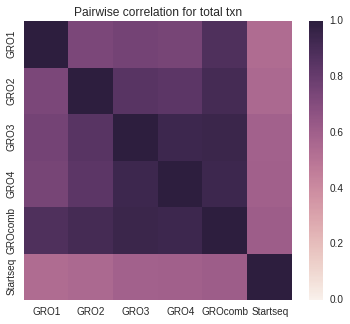

In [315]:
sns.plt.figure(figsize=[6,5])
sns.set(style="white")
log_total_finite = log_total.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
corr = log_total_finite.corr()
sns.heatmap(corr, vmin=0, vmax=1)
sns.plt.title("Pairwise correlation for total txn")

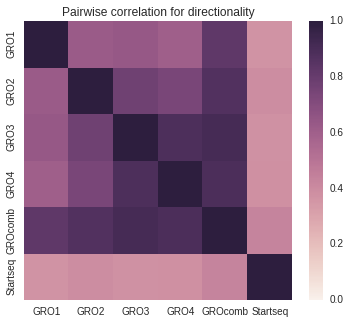

In [316]:
sns.plt.figure(figsize=[6,5])
sns.set(style="white")
log_direc_finite = log_direc.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
corr = log_direc_finite.corr()
sns.heatmap(corr, vmin=0, vmax=1)
sns.plt.title("Pairwise correlation for directionality")

Now only using GROcomb and Startseq

In [455]:
results = pd.concat([log_total["GROcomb"], log_total["Startseq"], log_direc["GROcomb"], log_direc["Startseq"]], axis=1)
results.columns = ["GROcomb_total", "Startseq_total", "GROcomb_direc", "Startseq_direc"]
print results.shape
results.head()

(73345, 4)


,GROcomb_total,Startseq_total,GROcomb_direc,Startseq_direc
regionName,,,,
chr10__100050901__100052901__100051905__bidir__DHSpeak_10229__7_Active_Promoter__64__+,2.676530,2.028329,-2.315269,-5.391503
chr10__100203865__100205865__100204865__nostartseqsig__DHSpeak_10230__12_Heterochrom__0__+,-inf,-inf,NaN,NaN
chr10__10040115__10042115__10041115__uni__DHSpeak_6386__12_Heterochrom__0__+,-3.458490,-2.259805,-inf,-inf
chr10__10074565__10076565__10075565__nostartseqsig__DHSpeak_6387__12_Heterochrom__0__+,-inf,-inf,NaN,NaN
chr10__101044763__101046763__101045955__bidir__DHSpeak_10232__12_Heterochrom__476__+,-1.881533,-3.684404,-2.046448,5.052868


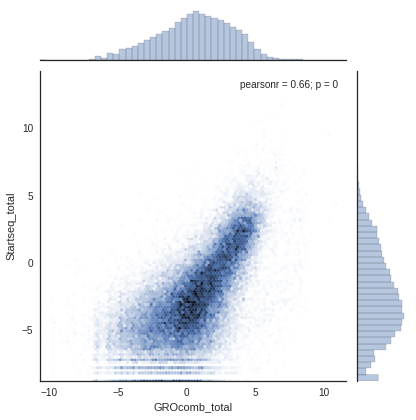

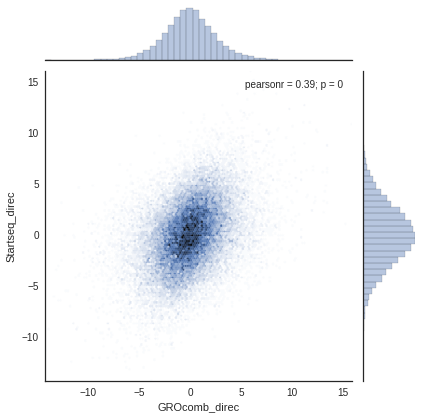

In [378]:
sns.jointplot(x="GROcomb_total", y="Startseq_total", data=results.replace([np.inf, -np.inf], np.nan), kind="hex")
sns.jointplot(x="GROcomb_direc", y="Startseq_direc", data=results.replace([np.inf, -np.inf], np.nan), kind="hex")

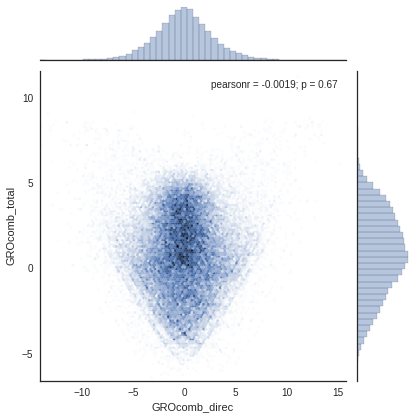

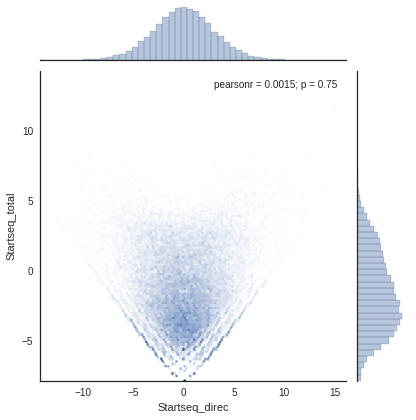

In [333]:
sns.jointplot(x="GROcomb_direc", y="GROcomb_total", data=results.replace([np.inf, -np.inf], np.nan), kind="hex")
sns.jointplot(x="Startseq_direc", y="Startseq_total", data=results.replace([np.inf, -np.inf], np.nan), kind="hex")

In [422]:
total = results.shape[0] 
xt = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["GROcomb_total", "Startseq_total"]).shape[0]
gt = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["GROcomb_total"]).shape[0]
st = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["Startseq_total"]).shape[0]
print "Number of elements with nonzero GRO and Startseq signal: {} ({:.3g}%)".format(xt, 100*float(xt)/total)
print "Number of elements with nonzero GRO signal: {} ({:.3g}%)".format(gt, 100*float(gt)/total)
print "Number of elements with nonzero Startseq signal: {} ({:.3g}%)".format(st,  100*float(st)/total)
print ""
xd = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["GROcomb_direc", "Startseq_direc"]).shape[0]
gd = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["GROcomb_direc"]).shape[0]
sd = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["Startseq_direc"]).shape[0]
print "Number of transcribed elements with finite (bidirec) GRO and Startseq directionality: {} ({:.3g}%)".format(xd, 100*float(xd)/xt)
print "Number of transcribed elements with finite (bidirec) GRO directionality: {} ({:.3g}%)".format(gd, 100*float(gd)/gt)
print "Number of transcribed elements with finite (bidirec) Startseq directionality: {} ({:.3g}%)".format(sd, 100*float(sd)/st)

Number of elements with nonzero GRO and Startseq signal: 53882 (73.5%)
Number of elements with nonzero GRO signal: 67143 (91.5%)
Number of elements with nonzero Startseq signal: 55963 (76.3%)

Number of transcribed elements with finite (bidirec) GRO and Startseq directionality: 36567 (67.9%)
Number of transcribed elements with finite (bidirec) GRO directionality: 50256 (74.8%)
Number of transcribed elements with finite (bidirec) Startseq directionality: 41726 (74.6%)


In [423]:
mask = results.dropna().replace([np.inf, -np.inf], [10, -10])
mask["samedirec"] = (np.sign(mask["GROcomb_direc"]) == np.sign(mask["Startseq_direc"]))
print mask[mask["samedirec"] == True].shape[0]
mask.head()

34409


,GROcomb_total,Startseq_total,GROcomb_direc,Startseq_direc,samedirec
regionName,,,,,
chr10__100050901__100052901__100051905__bidir__DHSpeak_10229__7_Active_Promoter__64__+,2.676530,2.028329,-2.315269,-5.391503,True
chr10__10040115__10042115__10041115__uni__DHSpeak_6386__12_Heterochrom__0__+,-3.458490,-2.259805,-10.000000,-10.000000,True
chr10__101044763__101046763__101045955__bidir__DHSpeak_10232__12_Heterochrom__476__+,-1.881533,-3.684404,-2.046448,5.052868,False
chr10__101479116__101481116__101480055__bidir__DHSpeak_10233__12_Heterochrom__236__+,-0.127992,-5.680779,1.974238,-1.715917,False
chr10__101832355__101834355__101833355__uni__DHSpeak_10234__12_Heterochrom__0__+,0.099174,-6.452963,-1.520350,-10.000000,True


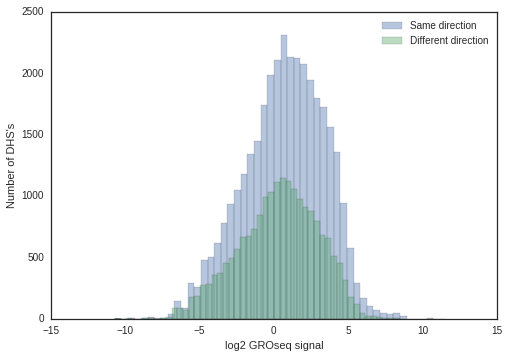

In [399]:
sns.distplot(mask[mask["samedirec"] == True]["GROcomb_total"], kde=False, label="Same direction")
sns.distplot(mask[mask["samedirec"] == False]["GROcomb_total"], kde=False, label="Different direction")
sns.plt.legend()
sns.plt.xlabel("log2 GROseq signal")
sns.plt.ylabel("Number of DHS's")

In [428]:
def in_window(n):
    x = mask[(mask["samedirec"]) & (mask["GROcomb_total"] > (n-1)) & (mask["GROcomb_total"] < n)].shape[0]
    y = mask[(mask["samedirec"] != True) & (mask["GROcomb_total"] > (n-1)) & (mask["GROcomb_total"] < n)].shape[0]
    return float(x)/(x+y)

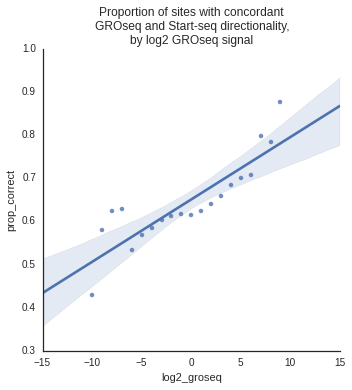

In [450]:
prop_correct = [in_window(n) for n in range(-10,10)]
df = pd.concat([pd.DataFrame(range(-10,10)), pd.DataFrame(prop_correct)], axis=1)
df.columns = ["log2_groseq", "prop_correct"]
sns.lmplot("log2_groseq", "prop_correct", df)
sns.plt.title("Proportion of sites with concordant \nGROseq and Start-seq directionality, \nby log2 GROseq signal")

Now we are going to label all DHS's by:
- direction (+ or -); default is +
- directionality score
- name

Name will contain
- chr/start/stop
- original DHS center
- original DHS number
- annotation
- distance between peaks

Data file will contain
- name
- GRO and Start-seq total and directionality

In [456]:
results.head()

,GROcomb_total,Startseq_total,GROcomb_direc,Startseq_direc
regionName,,,,
chr10__100050901__100052901__100051905__bidir__DHSpeak_10229__7_Active_Promoter__64__+,2.676530,2.028329,-2.315269,-5.391503
chr10__100203865__100205865__100204865__nostartseqsig__DHSpeak_10230__12_Heterochrom__0__+,-inf,-inf,NaN,NaN
chr10__10040115__10042115__10041115__uni__DHSpeak_6386__12_Heterochrom__0__+,-3.458490,-2.259805,-inf,-inf
chr10__10074565__10076565__10075565__nostartseqsig__DHSpeak_6387__12_Heterochrom__0__+,-inf,-inf,NaN,NaN
chr10__101044763__101046763__101045955__bidir__DHSpeak_10232__12_Heterochrom__476__+,-1.881533,-3.684404,-2.046448,5.052868


In [477]:
with open("interm/nb1/160504_dhs_grodirec.bed", 'w') as dhsfile, \
open("interm/nb1/160504_dhs_grodirec_data.txt", 'w') as datafile:
    dhswriter = csv.writer(dhsfile, 'textdialect')
    datawriter = csv.writer(datafile, 'textdialect')
    
    colnames = ['name']
    colnames.extend(results.columns)
    datawriter.writerow(colnames)
    
    for i in range(results.shape[0]):
        info = results.index[i].split('__')
        row = info[:3]
        name = '__'.join([info[0], info[1], info[2], info[3], info[5], info[6], info[7]])
        
        scores = results.ix[i,:]
        direc_score = scores[2]
        if np.isnan(direc_score): direc_score = 0
        strand = '-' if direc_score < 0 else '+'
        row.extend([name, np.abs(direc_score), strand])
        dhswriter.writerow(row)
        
        datarow = [name]
        datarow.extend(results.ix[i,:])
        datawriter.writerow(datarow)
! head interm/nb1/160504_dhs_grodirec.bed
! head interm/nb1/160504_dhs_grodirec_data.txt

chr10	100050901	100052901	chr10__100050901__100052901__100051905__DHSpeak_10229__7_Active_Promoter__64	2.315268634648572	-
chr10	100203865	100205865	chr10__100203865__100205865__100204865__DHSpeak_10230__12_Heterochrom__0	0	+
chr10	10040115	10042115	chr10__10040115__10042115__10041115__DHSpeak_6386__12_Heterochrom__0	inf	-
chr10	10074565	10076565	chr10__10074565__10076565__10075565__DHSpeak_6387__12_Heterochrom__0	0	+
chr10	101044763	101046763	chr10__101044763__101046763__101045955__DHSpeak_10232__12_Heterochrom__476	2.046447582106119	-
chr10	101479116	101481116	chr10__101479116__101481116__101480055__DHSpeak_10233__12_Heterochrom__236	1.9742381943480449	+
chr10	101832355	101834355	chr10__101832355__101834355__101833355__DHSpeak_10234__12_Heterochrom__0	1.5203500932621947	-
chr10	10191225	10193225	chr10__10191225__10193225__10192225__DHSpeak_6388__5_Active_Promoter__0	inf	-
chr10	101913595	101915595	chr10__101913595__101915595__101914595__DHSpeak_10235__12_Heterochrom__0	0	+
chr10	1022

In [478]:
! sort -k1,1 -k2,2n interm/nb1/160504_dhs_grodirec.bed > interm/nb1/160504_dhs_grodirec_sorted.bed

In [15]:
## 6/5/16 more analysis
gro_direc = []
prom = []
enh = []
with open("interm/nb1/160605_dhs_grodirec_data.txt", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    reader.next()
    for row in reader:
        gro_direc.append(float(row[4]))
        if 'Promoter' in row[0]: prom.append(float(row[4]))
        elif 'Enhancer' in row[0]: enh.append(float(row[4]))
gro_direc = np.array(gro_direc)
prom = np.array(prom)
enh = np.array(enh)

In [16]:
print len(gro_direc)
print len(gro_direc[np.abs(gro_direc)>1])
print len(prom)
print len(prom[np.abs(prom)>1])
print len(enh)
print len(enh[np.abs(enh)>1])

70575
42466
19734
14785
14340
9736
